#### Oppgave 1

innledning

### a)

In [1]:
import xarray as xr
from scipy.interpolate import RectBivariateSpline
import numpy as np
from matplotlib import pyplot as plt
from time import time
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import random
from interpolator import Interpolator


In [2]:
def f_first(x,t,epsilon, w) -> np.ndarray:
    """""
    function calculates function f used in velocity equation.
    :param x: array
    :param t: array
    :param epsilon: float
    :param w: float
    return array
    """""
    return epsilon*np.sin(w*t)*x**2 + (1-2*epsilon*np.sin(w*t))*x

def del_f(x,t,epsilon, w) -> np.ndarray:
    """""
    function calculates function f used in velocity equation.
    :param x: array
    :param t: array
    :param epsilon: float
    :param w: float
    return array
    """""
    return epsilon*np.sin(w*t)*2*x + (1-2*epsilon*np.sin(w*t))

def velocity_x(x: np.ndarray, y: np.ndarray, t: np.ndarray , A: float, epsilon: float, w: float) -> np.ndarray:
    """""
    function calculates velocity in x direction.
    :param x: array
    :param y: array
    :param t: array
    :param A: float
    :param epsilon: float
    :param w: float
    return array
    """""
    return -np.pi*A*np.sin(np.pi*f_first(x,t, epsilon, w))*np.cos(np.pi*y)

def velocity_y(x: np.ndarray, y: np.ndarray, t: np.ndarray , A: float, epsilon: float, w: float) -> np.ndarray:
    """""
    function calculates velocity in y direction.
    :param x: array
    :param y: array
    :param t: array
    :param A: float
    :param epsilon: float
    :param w: float
    return array
    """""
    return np.pi*A*np.cos(np.pi*f_first(x,t, epsilon, w))*np.sin(np.pi*y)*del_f(x,t, epsilon, w)

def Heun(init_pos: tuple, t_end: int, h: float, A: float, epsilon: float, w: float) -> np.ndarray:
    """""
    function uses the Heun integrate method to calculate the next position for the particle
    :param init_pos: tuple
    :param t_end: int
    :param h: float
    :param A: float
    :param epsilon: float
    :param w: float
    return [array, array]
    """""
    num_particles = init_pos.shape[2]
    
    t = 0
    steps = int(t_end / h)
    x = np.empty((steps + 1, 2, num_particles))
    x[:, :, :] = init_pos

    for i in range(steps):
        k_1_x = velocity_x(x[i, 0, :], x[i, 1, :], t, A, epsilon, w)
        k_1_y = velocity_y(x[i, 0, :], x[i, 1, :], t, A, epsilon, w)

        k_2_x = velocity_x(x[i, 0, :] + k_1_x * h, x[i, 1, :] + k_1_y * h, t+h , A, epsilon, w)
        k_2_y = velocity_y(x[i, 0, :] + k_1_x * h, x[i, 1, :] + k_1_y * h, t+h , A, epsilon, w)

        x_add_x = x[i, 0, :] + (h / 2) * (k_1_x + k_2_x)
        x_add_y = x[i, 1, :] + (h / 2) * (k_1_y + k_2_y)

        x[i + 1, 0, :] = x_add_x
        x[i + 1, 1, :] = x_add_y
        t += h
    return x

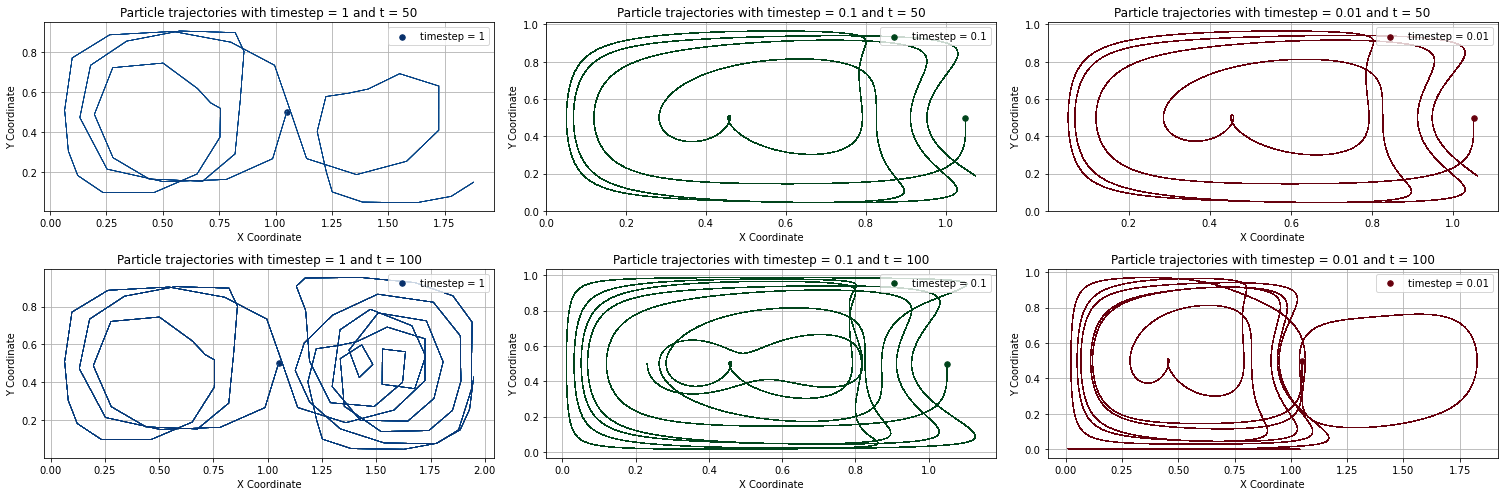

In [3]:
#plotter bevegelsen til partikkel ved hjelp av Heun metode, med gitte initialverdier og konstanter
A = 0.1
epsilon = 0.25
w = 1
init_pos = np.array([[[1.05, 0.5]]]).reshape(1,2,1) #startposisjon
t = 50
h = [1, 0.1, 0.01]
cmaps = [plt.get_cmap('Blues'), plt.get_cmap('Greens'), plt.get_cmap('Reds')]
fig, axs =plt.subplots(2,3, figsize = (21,7))
for i in range(len(h)):    
    positions = Heun(init_pos, t, h[i], A, epsilon, w) #gir array med posisjon for partikkelen
    cmap = cmaps[i]
    num_pos = positions.shape[0]
    for idx in range(positions.shape[0]): 
        x = positions[:,0, :]
        y = positions[:,1, :] 
        axs[0,i].plot(x, y, color = cmap(idx/num_pos),  alpha=0.5, lw=0.5)
    axs[0,i].set_xlabel('X Coordinate')
    axs[0,i].set_ylabel('Y Coordinate')
    axs[0,i].set_title(f'Particle trajectories with timestep = {h[i]} and t = {t}')
    axs[0,i].scatter(init_pos[:,0,:], init_pos[:,1,:], label = f'timestep = {h[i]}', color = cmap(1000), s = 30)
    axs[0,i].legend(loc = 1)
    axs[0,i].grid(True)
t = 100
for i in range(len(h)):    
    positions = Heun(init_pos, t, h[i], A, epsilon, w) #gir array med posisjon for partikkelen
    cmap = cmaps[i]
    num_pos = positions.shape[0]
    for idx in range(positions.shape[0]): 
        x = positions[:,0, :]
        y = positions[:,1, :] 
        axs[1,i].plot(x, y, color = cmap(idx/num_pos),  alpha=0.5, lw=0.5)
    axs[1,i].set_xlabel('X Coordinate')
    axs[1,i].set_ylabel('Y Coordinate')
    axs[1,i].set_title(f'Particle trajectories with timestep = {h[i]} and t = {t}')
    axs[1,i].scatter(init_pos[:,0,:], init_pos[:,1,:], label = f'timestep = {h[i]}', color = cmap(1000), s = 30)
    axs[1,i].legend(loc = 1)
    axs[1,i].grid(True)
plt.tight_layout()

diskuter h vi velger å bruke videre, liker vi denne for t = 50 og t = 100?

### b)

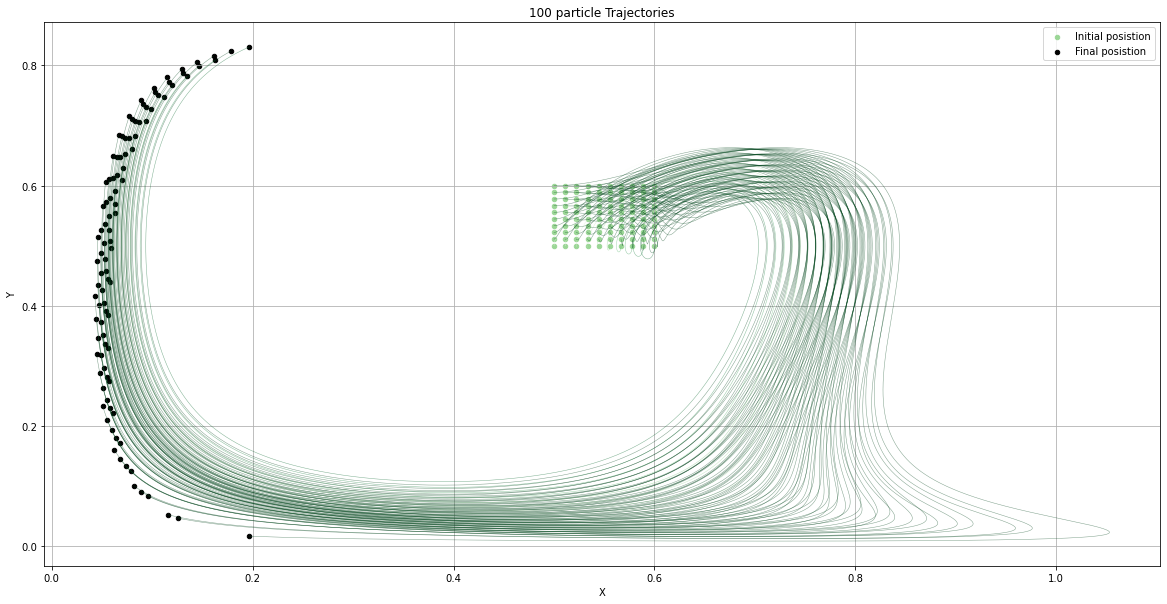

In [4]:
#this is a test

N_p = 100
t = 10
A = 0.1
epsilon = 0.25
w = 1
h = 0.01
num_points = int(N_p / 10)

x_cor = np.linspace(0.5, 0.6, num_points)
y_cor = np.linspace(0.5, 0.6, num_points)
x_grid, y_grid = np.meshgrid(x_cor, y_cor)
init_pos = np.stack((x_grid, y_grid))
init_pos = init_pos.reshape(1, 2, -1) #creates grid 

cmap = plt.get_cmap('Greens')
plt.figure(figsize = (20,10))
positions = Heun(init_pos, t, h, A, epsilon, w)
plt.scatter(positions[0,0,:], positions[0,1,:], label = "Initial posistion", color = cmap(100), s = 20)
plt.scatter(positions[-1,0,:], positions[-1,1,:], label = "Final posistion", color = "black", s = 20)
for i in range(N_p):
    plt.plot(positions[:, 0, i], positions[:, 1, i],color = cmap(i*10/N_p),  alpha=0.5, lw=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('100 particle Trajectories')
plt.legend()
plt.grid(True)
plt.show()




endre til grid istedenfor random_uniform?

### c)

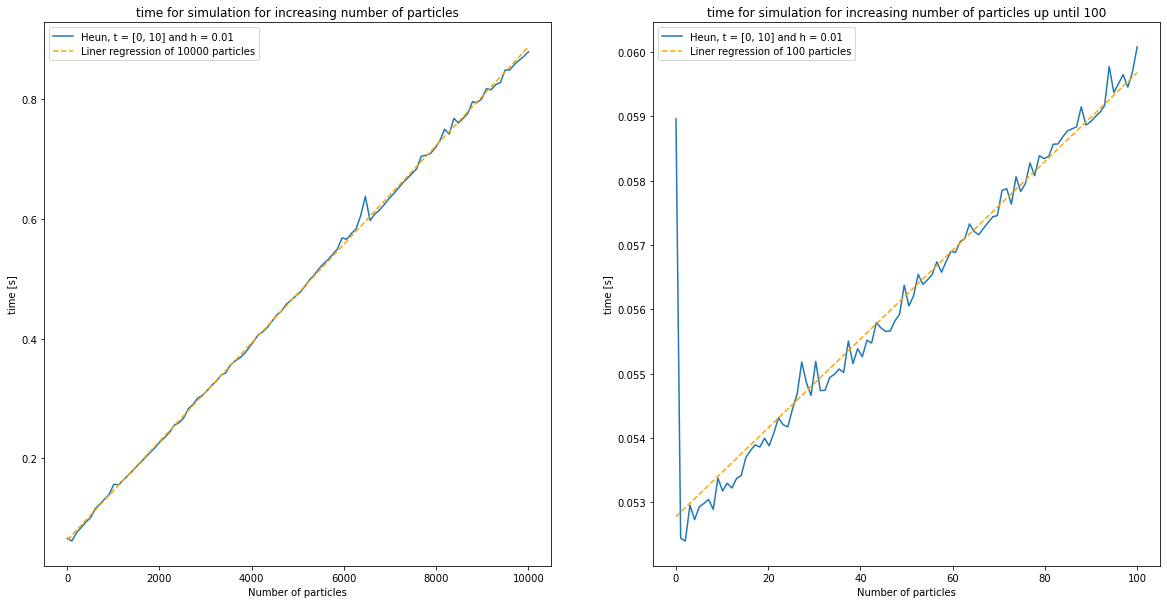

In [5]:
import time
N_p = 10000
N_p2 = 100
steps = 100
h = 0.01
t = 10
time_list = []
time_list2 = []

for i in range(0,N_p,steps):
    start = time.time()
    ones= np.ones(i)
    init_pos = np.array([[ones*1.05, ones*0.5]])
    Heun(np.array(init_pos), t, h,A, epsilon, w)
    end = time.time()
    time_list.append(end-start)


for i in range(0,N_p2):
    start = time.time()
    ones= np.ones(i)
    init_pos = np.array([[ones*1.05, ones*0.5]])
    Heun(np.array(init_pos), t, h,A, epsilon, w)
    end = time.time()
    time_list2.append(end-start)

lin_reg_10000 = np.polyval(np.polyfit(np.linspace(0, N_p, len(time_list)), time_list, deg=1), np.linspace(0, N_p, len(time_list)))
lin_reg_100 = np.polyval(np.polyfit(np.linspace(0, N_p2, len(time_list2)), time_list2, deg=1), np.linspace(0, N_p2, len(time_list2)))


#Ploting of simulations
fig, axs =plt.subplots(1,2, figsize = (20,10))

axs[0].plot(np.linspace(0, N_p, len(time_list)), time_list, label = "Heun, t = [0, 10] and h = 0.01")
axs[0].plot(np.linspace(0, N_p, len(time_list)), lin_reg_10000, linestyle="dashed", label= "Liner regression of 10000 particles", color = "orange")
axs[0].set_xlabel("Number of particles")
axs[0].set_ylabel("time [s]")
axs[0].set_title("time for simulation for increasing number of particles")
axs[0].legend(loc = 2)


axs[1].plot(np.linspace(0, N_p2, len(time_list2)), time_list2, label = "Heun, t = [0, 10] and h = 0.01")
axs[1].plot(np.linspace(0, N_p2, len(time_list2)), lin_reg_100, linestyle="dashed", label= "Liner regression of 100 particles", color = "orange")
axs[1].set_xlabel("Number of particles")
axs[1].set_ylabel("time [s]")
axs[1].set_title("time for simulation for increasing number of particles up until 100")
axs[1].legend(loc = 2)
plt.show()


forklare hvorfor vi ikke har logaritmisk skala, kanskje endre til logaritmisk skala? måten vi gjør dette på, ved bruk av batches som step forbedret løpetid. hvorfor konstant for lave Np. 

## Oppgave 2)

### a og b)

In [12]:
def Heun_2(X: np.ndarray, days: int, h: int, f):
    t_end = days * 24 * h
    steps = int(t_end / h)
    num_particles = X.shape[1]
    x = np.empty((steps + 1, 2, num_particles))
    x[:, :, :] = X
    t = 0
    for i in range(steps):
        k_1 = f(X, t)
        k_2 = f(X + h * k_1, t + h)
        X_next = (X + (h / 2) * (k_1 + k_2)).reshape(1, 2, num_particles)
        X = X_next[-1, :, :]
        x[i + 1, :, :] = X
        t += h
    return x


def distance_traveled_optimized(x: np.ndarray):
    diff_NS = np.diff(x[:, 0, :], axis=0)
    diff_WE = np.diff(x[:, 1, :], axis=0)

    sqrt_distances = diff_NS**2 + diff_WE**2

    distances = np.sqrt(np.sum(sqrt_distances, axis=0))

    mean_distance = np.mean(distances)
    max_distance = np.max(distances)
    
    return mean_distance, max_distance

def distance_traveled(x: np.ndarray):
    distance_arr = np.zeros(x.shape[2])

    for i in range(x.shape[2]):
        diff_NS = np.diff(x[:, 0, i])
        diff_WE = np.diff(x[:, 1, i])

        distance = np.sum(np.sqrt(diff_NS**2 + diff_WE**2))
        distance_arr[i] = distance
    
    return np.mean(distance_arr), np.max(distance_arr) 

In [7]:
file_path = "NorKyst-800m.nc"

d = xr.open_dataset(file_path)

f  = Interpolator(dataset = d)

h = 3600
days = 5
Np = 400

X_1 = np.zeros((2,Np))
X_1[0,:] = np.random.normal(loc = 790000, scale=10000, size = Np)
X_1[1,:] = np.random.normal(loc = 490000, scale=10000, size = Np)

X_2 = np.zeros((2, Np))
X_2[0,:] = np.random.normal(loc = 1240000, scale=10000, size = Np)
X_2[1,:] = np.random.normal(loc = 480000, scale=10000, size = Np)

position_trondheim = Heun_2(X_1, days, h, f)
f  = Interpolator(dataset = d)
position_lofoten = Heun_2(X_2, days, h, f)


avg_dis_tro, max_dis_tro = distance_traveled(position_trondheim)
avg_dis_lof, max_dis_lof = distance_traveled(position_lofoten)

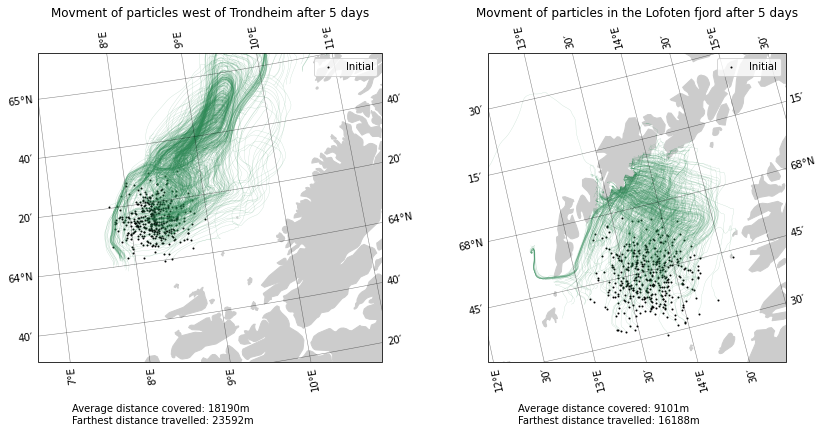

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.NorthPolarStereo()})

# Create projection object for converting particle positions
npstere = ccrs.Stereographic(
    central_latitude=90,
    central_longitude=f.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting=f.dataset.projection_stere.false_easting,
    false_northing=f.dataset.projection_stere.false_northing,
    true_scale_latitude=f.dataset.projection_stere.standard_parallel,
)

# Plot position_trondheim
axs[0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color='#cccccc'))
axs[0].scatter(position_trondheim[0, 0, :], position_trondheim[0, 1, :], s=1, transform=npstere, label='Initial', color = 'black')
for j in range(position_trondheim.shape[2]):
    axs[0].plot(position_trondheim[:, 0, j], position_trondheim[:, 1, j], transform=npstere, alpha=0.3, lw=0.3, color = 'seagreen')
axs[0].set_extent((7, 11, 63.5, 65))
axs[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5)
axs[0].set_title("Movment of particles west of Trondheim after 5 days")
axs[0].text(0.1, -0.2, f'Average distance covered: {int(avg_dis_tro)}m\nFarthest distance travelled: {int(max_dis_tro)}m',
             transform=axs[0].transAxes, ha='left')
axs[0].legend()

# Plot position_tromsoe
axs[1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color='#cccccc'))
axs[1].scatter(position_lofoten[0, 0, :], position_lofoten[0, 1, :], s=1, transform=npstere, label='Initial', color = 'black')
for j in range(position_lofoten.shape[2]):
    axs[1].plot(position_lofoten[:, 0, j], position_lofoten[:, 1, j], transform=npstere, alpha=0.3, lw=0.3, color = 'seagreen')
axs[1].set_extent((12.5, 15, 67.5, 68.5))
axs[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5)
axs[1].set_title("Movment of particles in the Lofoten fjord after 5 days")
axs[1].text(0.1, -0.2, f'Average distance covered: {int(avg_dis_lof)}m\nFarthest distance travelled: {int(max_dis_lof)}m',
             transform=axs[1].transAxes, ha='left')
axs[1].legend()


plt.tight_layout()
plt.show()


## Oppgave 3)


a)

In [9]:
def Heun_3(X: np.ndarray, days: int, h: int, f):

    t_end = days*24*h
    t = 0
    steps = int(t_end / h)
    num_particles = X.shape[1]
    x = np.empty((steps + 1, 2, num_particles))
    x[:, :, :] = X
    for i in range(0,steps):
        k_1 = f(X, t)
        k_2 = (f(X+ k_1*i*h,t + i*h))
        
        on_land = f.on_land(X.reshape(2, num_particles))
        on_land = np.where(on_land, 0, 1)
        on_land = np.array([on_land, on_land]).reshape(1,2, num_particles)

        X_next = (X + (h / 2) * (k_1 + k_2)*on_land).reshape(1,2,num_particles)
        X = X_next[-1,:,:]
        x[i + 1, :, :] = X
        t += h
    return x

In [10]:
h = 3600
days = 3
Np = 500
f_w = np.linspace(0,0.15, 15)
interpol = []
for i in f_w:
    interpol.append(Interpolator(dataset = d, fw = i))
# X_3 = np.zeros((2,Np))
# X_3[0,:] = np.random.normal(loc = 250000, scale=10000, size = Np)
# X_3[1,:] = np.random.normal(loc = 460000, scale=10000, size = Np)

X_3 = np.zeros((2,Np))
X_3[0,:] = np.random.normal(loc = 1240000, scale=10000, size = Np)
X_3[1,:] = np.random.normal(loc = 480000, scale=10000, size = Np)

pos = []
for j in interpol:
    pos.append(Heun_3(X_3, days, h, j))




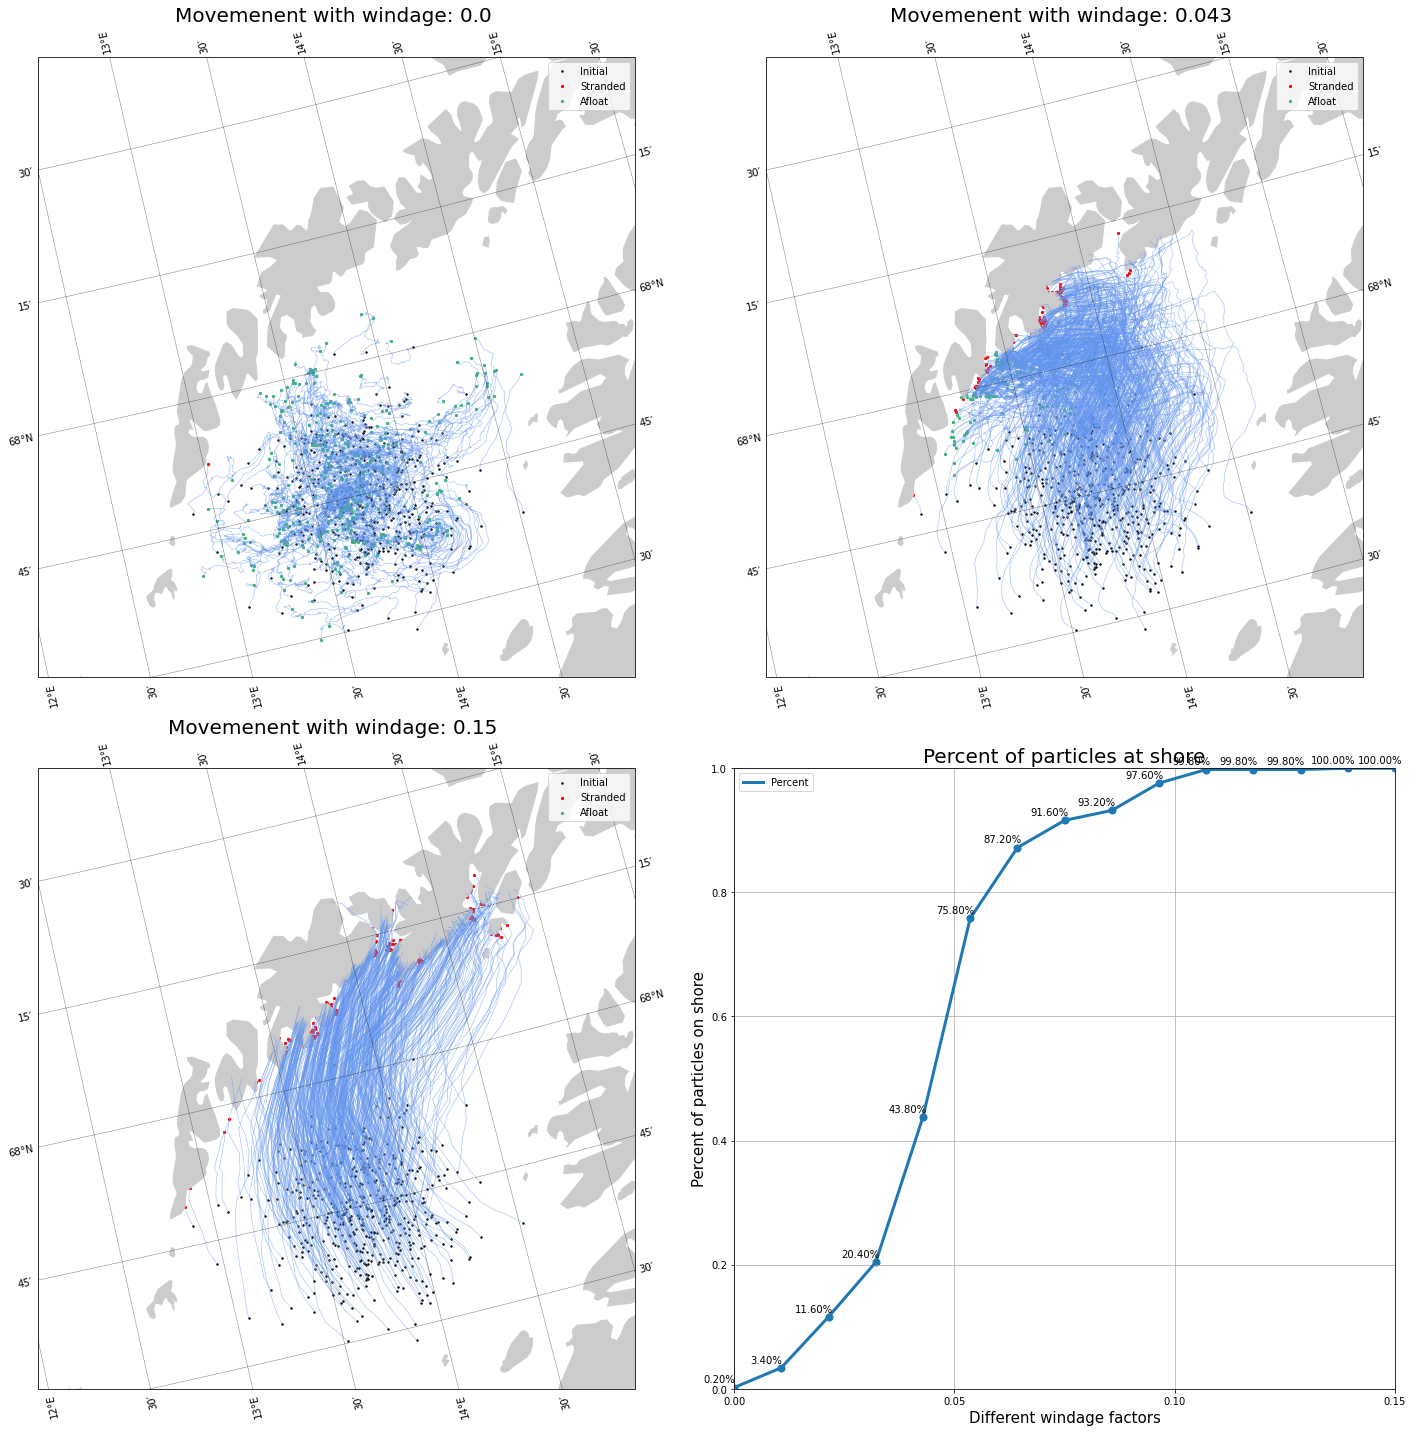

In [11]:
fig, axs = plt.subplots(2,2, figsize=(20, 20), subplot_kw={'projection': ccrs.NorthPolarStereo()})

npstere = ccrs.Stereographic(
    central_latitude = 90,
    central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting = f.dataset.projection_stere.false_easting,
    false_northing = f.dataset.projection_stere.false_northing,
    true_scale_latitude = f.dataset.projection_stere.standard_parallel,
)
f_w_0 = [f_w[0], f_w[4], f_w[14]]
position = [pos[0], pos[4], pos[14]]

for i in range(len(f_w_0)):
    axs[i // 2, i % 2].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color='#cccccc'))
    axs[i // 2, i % 2].scatter(position[i][0, 0, :], position[i][0, 1, :], s=2, color = 'black', transform=npstere, label='Initial')
    on_land = f.on_land(position[i][-1,:,:])
    axs[i // 2, i % 2].scatter(position[i][-1, 0, :]*on_land, position[i][-1, 1, :]*on_land, color = 'red', s=5, transform=npstere, label='Stranded')
    axs[i // 2, i % 2].scatter(position[i][-1, 0, :]*~on_land, position[i][-1, 1, :]*~on_land, color = 'mediumseagreen', s=5, transform=npstere, label='Afloat')
    for j in range(position[i].shape[2]):
        axs[i // 2, i % 2].plot(position[i][:, 0, j], position[i][:, 1, j], transform=npstere, color = 'cornflowerblue',  alpha=0.6, lw=0.6)
    axs[i // 2, i % 2].set_extent((3.3, 5.5, 59.3, 61.5))
    axs[i//2, i%2].set_extent((12.5, 15, 67.5, 68.5))
    axs[i // 2, i % 2].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5)
    axs[i // 2, i % 2].set_title(f'Movemenent with windage: {np.round(f_w_0[i],3)} ', fontsize = 20)
    axs[i // 2, i % 2].set_xlabel('North')
    axs[i // 2, i % 2].set_ylabel('East')
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].set_xlabel('East', fontsize = 15)
    axs[i // 2, i % 2].set_ylabel('North', fontsize = 15)
percent = []
for i in range(15):
    percent.append(np.sum(interpol[i].on_land(pos[i][-1,:,:]))/pos[i].shape[2])
axs[1,1].plot(f_w, percent, label = 'Percent', lw = 3)
axs[1,1].scatter(f_w, percent, s = 50)
for i, (x, y) in enumerate(zip(f_w, percent)):
    axs[1,1].annotate(f'{y*100:.2f}%', (x, y), textcoords="offset points", xytext=(-15,5), ha='center')
axs[1,1].set_title('Percent of particles at shore', fontsize = 20)
axs[1,1].set_aspect('auto') 
axs[1,1].set_xticks([0, 0.05, 0.1, 0.15])  
axs[1,1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs[1,1].set_xlim(0, 0.15) 
axs[1,1].set_ylim(0, 1)
axs[1,1].set_xlabel('Different windage factors', fontsize = 15)
axs[1,1].set_ylabel('Percent of particles on shore', fontsize = 15)
axs[1,1].grid(True)
axs[1,1].legend(loc = 2)
plt.tight_layout()

konklusjon